In [ ]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load Extracted features



In [ ]:
text_features = pd.read_csv("/content/gdrive/MyDrive/Master Centrale/Projet/datasets/ft_bag_of_words.csv").drop(columns=['Unnamed: 0'])

In [ ]:
img_features = pd.read_csv("/content/gdrive/MyDrive/Master Centrale/Projet/datasets/img_features.csv").drop(columns=['Unnamed: 0'])

In [ ]:
path_to_target ="/content/gdrive/MyDrive/Master Centrale/Projet/datasets/target_reduced.txt"
labels = np.loadtxt(path_to_target, dtype=int)
labels = torch.tensor(labels, dtype=torch.float)

In [ ]:
#reformat labels 
labels = [int(x.argmax()) for x in labels]

In [ ]:
type(text_features)

pandas.core.frame.DataFrame

In [ ]:
type(img_features)

pandas.core.frame.DataFrame

In [ ]:
type(labels)

list

## train classifier with each modality

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

We first try to learn a model on each modality to evaluate the quality of each representation

### text modality

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(text_features, labels, test_size=0.3, random_state=42)

In [ ]:
rfc=RandomForestClassifier(random_state=42)

In [ ]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)
model = CV_rfc.best_estimator_
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 500}

In [ ]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,model.predict(x_test)))

Accuracy for Random Forest on CV data:  0.7239263803680982


### image modality

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(img_features, labels, test_size=0.3, random_state=42)
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)
model = CV_rfc.best_estimator_
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 500}

In [ ]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,model.predict(x_test)))

Accuracy for Random Forest on CV data:  0.852760736196319


In [ ]:
img_features.shape

(543, 524)

In [ ]:
##select the two representations 

X = img_features.copy()
X_mc = (X-X.mean())/(X.std())
X_mc.head(1)

,0,1,2,3,4,5,6,7,8,9,...,514,515,516,517,518,519,520,521,522,523
0,-0.485781,-0.441445,2.413909,-0.457076,0.202982,-0.432629,-0.373863,-0.429223,-0.402408,0.100705,...,-0.253944,0.807847,-0.482212,3.855111,-0.504401,-0.598332,-0.376437,-0.198483,-0.460056,-0.32694


In [ ]:
##select the two representations 

Y = text_features.copy()
Y_mc = (Y-Y.mean())/(Y.std())
Y_mc.head(1)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.892493,2.515187,-0.156471,-1.711123,-0.104554,-1.398269,-0.159332,-2.180029,-0.311113,-0.147583,...,-0.200389,-0.27406,-1.09069,-1.422873,-0.371631,-0.371631,-0.425003,-1.964124,-1.167362,-0.252176


In [ ]:
## if std ==0 value become nan, but it's the case for all the column we can drop it 
Y_mc = Y_mc.dropna(axis=1)
X_mc = X_mc.dropna(axis=1)

# Canonical Correlation Analysis with Scikit-learn

In [ ]:
from sklearn.cross_decomposition import CCA

In [ ]:
nb_component_to_keep = min(len(X_mc.columns),len(Y_mc.columns))

In [ ]:
ca = CCA(n_components=82)
ca.fit(X_mc, Y_mc)
X_c, Y_c = ca.transform(X_mc, Y_mc)

#Y residual is constant at iteration 82

/usr/local/lib/python3.7/dist-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


In [ ]:
import numpy as np
np.corrcoef(X_c[:, 7], Y_c[:, 7])


array([[1.        , 0.99993901],
       [0.99993901, 1.        ]])

In [ ]:
#save CCA results in dataframes
df_X_c = pd.DataFrame(X_c, columns = [f'X_{i}' for i in range(len(X_c[0]))])
df_Y_c = pd.DataFrame(Y_c, columns = [f'Y_{i}' for i in range(len(Y_c[0]))])

In [ ]:
##concat results in a df 

In [ ]:
#df_cca = pd.concat([df_cca, df_X_c], axis=1)
df_cca = pd.concat([df_X_c, df_Y_c], axis=1)

In [ ]:
df_cca.columns

Index(['X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9',
       ...
       'Y_72', 'Y_73', 'Y_74', 'Y_75', 'Y_76', 'Y_77', 'Y_78', 'Y_79', 'Y_80',
       'Y_81'],
      dtype='object', length=164)

We can now plot an instance of the new features of the dataset, the new features have been compute in by maximizing the correlation that's why it appear as a line

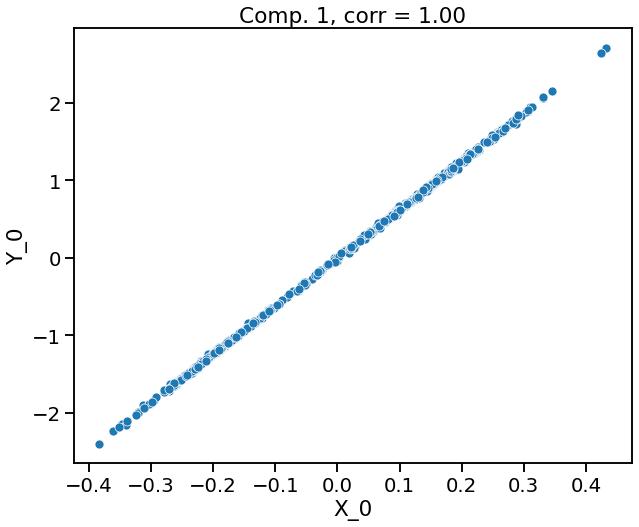

In [ ]:
%matplotlib inline
sns.set_context("talk", font_scale=1.2)
plt.figure(figsize=(10,8))
sns.scatterplot(x="X_0",
                y="Y_0", 
                data=df_cca)
plt.title('Comp. 1, corr = %.2f' %
         np.corrcoef(X_c[:, 20], Y_c[:, 20])[0, 1])

plt.show()

In [ ]:
#df_cca.to_csv("/Users/jeanloubet/Documents/Master_Centrale/Projet/datasets/datasets_after_cca.csv")

## Train model on CCA

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_cca, labels, test_size=0.3, random_state=42)
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)
model = CV_rfc.best_estimator_
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'log2',
 'n_estimators': 500}

In [ ]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,model.predict(x_test)))

Accuracy for Random Forest on CV data:  0.558282208588957


In [ ]:
#### find best number of components
for i in range(77,82): 
    columns_to_keep = [f'X_{i}' for i in range(i)]+[f'Y_{i}' for i in range(i)]
    data_reduced = df_cca[columns_to_keep]

    x_train, x_test, y_train, y_test = train_test_split(data_reduced, labels, test_size=0.3, random_state=42)
    rfc=RandomForestClassifier(random_state=42)

    param_grid = { 
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4,5,6,7,8],
        'criterion' :['gini', 'entropy']
    }
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(x_train, y_train)
    model = CV_rfc.best_estimator_
    CV_rfc.best_params_

    print(f"Accuracy for {i} components : ",accuracy_score(y_test,model.predict(x_test)))

"""
Accuracy for 1 components :  0.2085889570552147
Accuracy for 2 components :  0.22699386503067484
Accuracy for 3 components :  0.26993865030674846
Accuracy for 4 components :  0.25153374233128833
Accuracy for 5 components :  0.27607361963190186
Accuracy for 6 components :  0.32515337423312884
Accuracy for 7 components :  0.3374233128834356
Accuracy for 8 components :  0.36809815950920244
Accuracy for 9 components :  0.3496932515337423
Accuracy for 10 components :  0.3803680981595092
Accuracy for 11 components :  0.3374233128834356
Accuracy for 12 components :  0.4171779141104294
Accuracy for 13 components :  0.39263803680981596
Accuracy for 14 components :  0.43558282208588955
Accuracy for 15 components :  0.4601226993865031
Accuracy for 16 components :  0.4294478527607362
Accuracy for 17 components :  0.4110429447852761
Accuracy for 18 components :  0.4294478527607362
Accuracy for 19 components :  0.43558282208588955
Accuracy for 20 components :  0.44171779141104295
Accuracy for 21 components :  0.3803680981595092
Accuracy for 22 components :  0.4294478527607362
Accuracy for 23 components :  0.3987730061349693
Accuracy for 24 components :  0.44171779141104295
Accuracy for 25 components :  0.4539877300613497
Accuracy for 26 components :  0.44171779141104295
Accuracy for 27 components :  0.4723926380368098
Accuracy for 28 components :  0.44171779141104295
Accuracy for 29 components :  0.4785276073619632
Accuracy for 30 components :  0.49079754601226994
Accuracy for 31 components :  0.49693251533742333
Accuracy for 32 components :  0.49079754601226994
Accuracy for 33 components :  0.49693251533742333
Accuracy for 34 components :  0.5276073619631901
Accuracy for 35 components :  0.49079754601226994
Accuracy for 36 components :  0.48466257668711654
Accuracy for 37 components :  0.5153374233128835
Accuracy for 38 components :  0.5030674846625767
Accuracy for 39 components :  0.5030674846625767
Accuracy for 40 components :  0.5276073619631901
Accuracy for 41 components :  0.4662576687116564
Accuracy for 42 components :  0.5276073619631901
Accuracy for 43 components :  0.5276073619631901
Accuracy for 44 components :  0.49693251533742333
Accuracy for 45 components :  0.49693251533742333
Accuracy for 46 components :  0.558282208588957
Accuracy for 47 components :  0.5705521472392638
Accuracy for 48 components :  0.5153374233128835
Accuracy for 49 components :  0.50920245398773
Accuracy for 50 components :  0.5214723926380368
Accuracy for 51 components :  0.5214723926380368
Accuracy for 52 components :  0.5276073619631901
Accuracy for 53 components :  0.5644171779141104
Accuracy for 54 components :  0.5276073619631901
Accuracy for 55 components :  0.5398773006134969
Accuracy for 56 components :  0.5521472392638037
Accuracy for 57 components :  0.5337423312883436
Accuracy for 58 components :  0.5460122699386503
Accuracy for 59 components :  0.5644171779141104
Accuracy for 60 components :  0.5766871165644172
Accuracy for 61 components :  0.5398773006134969
Accuracy for 62 components :  0.558282208588957
Accuracy for 63 components :  0.5705521472392638
Accuracy for 64 components :  0.5521472392638037
Accuracy for 65 components :  0.5644171779141104
Accuracy for 66 components :  0.5337423312883436
Accuracy for 67 components :  0.5828220858895705
Accuracy for 68 components :  0.5766871165644172
Accuracy for 69 components :  0.6012269938650306
Accuracy for 70 components :  0.5950920245398773
Accuracy for 71 components :  0.5460122699386503
Accuracy for 72 components :  0.5705521472392638
Accuracy for 73 components :  0.6073619631901841
Accuracy for 74 components :  0.5398773006134969
Accuracy for 75 components :  0.5460122699386503
Accuracy for 76 components :  0.6196319018404908
Accuracy for 77 components :  0.5521472392638037
Accuracy for 78 components :  0.558282208588957
Accuracy for 79 components :  0.5950920245398773
Accuracy for 80 components :  0.5950920245398773
Accuracy for 81 components :  0.5644171779141104
"""

Accuracy for 77 components :  0.5521472392638037
Accuracy for 78 components :  0.558282208588957
Accuracy for 79 components :  0.5950920245398773
Accuracy for 80 components :  0.5950920245398773
Accuracy for 81 components :  0.5644171779141104


'\nAccuracy for 1 components :  0.2085889570552147\nAccuracy for 2 components :  0.22699386503067484\nAccuracy for 3 components :  0.26993865030674846\nAccuracy for 4 components :  0.25153374233128833\nAccuracy for 5 components :  0.27607361963190186\nAccuracy for 6 components :  0.32515337423312884\nAccuracy for 7 components :  0.3374233128834356\nAccuracy for 8 components :  0.36809815950920244\nAccuracy for 9 components :  0.3496932515337423\nAccuracy for 10 components :  0.3803680981595092\nAccuracy for 11 components :  0.3374233128834356\nAccuracy for 12 components :  0.4171779141104294\nAccuracy for 13 components :  0.39263803680981596\nAccuracy for 14 components :  0.43558282208588955\nAccuracy for 15 components :  0.4601226993865031\nAccuracy for 16 components :  0.4294478527607362\nAccuracy for 17 components :  0.4110429447852761\nAccuracy for 18 components :  0.4294478527607362\nAccuracy for 19 components :  0.43558282208588955\nAccuracy for 20 components :  0.441717791411042

The best result is obtained with 76 components we then obtain a score of 0.61. The score is really low and lower than when using each modality separately. It seems that the CCA lost a lot of information when applying its transformation.



## Try with both features without cca

In [ ]:
#df_both = pd.concat([text_features, img_features], axis=1)
df_both = pd.concat([Y_mc, X_mc], axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_both, labels, test_size=0.3, random_state=42)
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)
model = CV_rfc.best_estimator_
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 500}

In [ ]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,model.predict(x_test)))

Accuracy for Random Forest on CV data:  0.9079754601226994


Just by concatzenating the modalities we obtain a much better score

## Try PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(df_both)
principalDf = pd.DataFrame(data = principalComponents)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(principalDf, labels, test_size=0.3, random_state=42)
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)
model = CV_rfc.best_estimator_
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 500}

In [ ]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,model.predict(x_test)))

Accuracy for Random Forest on CV data:  0.9079754601226994


In [ ]:
for nb_compo in [10,20,30,40,50,60,70,80,90,100]:
    print(f"NB COMPONENTS= {nb_compo}")
    pca = PCA(n_components=nb_compo)
    principalComponents = pca.fit_transform(df_both)
    principalDf = pd.DataFrame(data = principalComponents)
    x_train, x_test, y_train, y_test = train_test_split(principalDf, labels, test_size=0.3, random_state=42)
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4,5,6,7,8],
        'criterion' :['gini', 'entropy']
    }
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(x_train, y_train)
    model = CV_rfc.best_estimator_
    CV_rfc.best_params_
    print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,model.predict(x_test)))


NB COMPONENTS= 10
Accuracy for Random Forest on CV data:  0.8834355828220859
NB COMPONENTS= 20
Accuracy for Random Forest on CV data:  0.9079754601226994
NB COMPONENTS= 30
Accuracy for Random Forest on CV data:  0.9141104294478528
NB COMPONENTS= 40
Accuracy for Random Forest on CV data:  0.9079754601226994
NB COMPONENTS= 50
Accuracy for Random Forest on CV data:  0.9141104294478528
NB COMPONENTS= 60
Accuracy for Random Forest on CV data:  0.901840490797546
NB COMPONENTS= 70
Accuracy for Random Forest on CV data:  0.901840490797546
NB COMPONENTS= 80
Accuracy for Random Forest on CV data:  0.901840490797546
NB COMPONENTS= 90
Accuracy for Random Forest on CV data:  0.9202453987730062
NB COMPONENTS= 100
Accuracy for Random Forest on CV data:  0.8895705521472392


Finally applying a PCA improve our performances, 0.92 seems to be enough to apply our causality method